

# Week 7

**Welcome to Assignment 3 on Deep Learning for Computer Vision.**

This assignment is based on the content you learned in Week-7 of the course.


#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

## Triplet loss:

In this question you will implement triplet loss for MNIST dataset.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler
from torch.optim import lr_scheduler
from PIL import Image
import timeit
from torchvision.datasets import MNIST
from torchvision import transforms
import cv2
from google.colab.patches import cv2_imshow

## Please DONOT remove these lines.
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)
########################

cuda = torch.cuda.is_available()
#### YOUR CODE STARTS HERE ####
# Check availability of GPU and set the device accordingly
device = torch.device("cuda" if cuda else "cpu")
#### YOUR CODE ENDS HERE ####


In [ ]:

#Prepare dataset
train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.1307,), (0.3081,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                            ]))
n_classes = 10


###Create dataset for Triplet Network

In [ ]:
class TripletDataset(Dataset):
    """
    This program returns anchor, positive and negative sample for training
    Creates fixed triplets for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform
        # Prepare labels and data for extracting positive and negative samples during training
        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}
        #### YOUR CODE STARTS HERE ####
        # Refering to the above code where we prepared labels and data for testing, please prepare test samples
        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

       #### YOUR CODE ENDS HERE ####
            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
          #### YOUR CODE STARTS HERE ####
            # assign train_data[index] to anchor and train_label[index] item() to label1
            anchor, label1 = self.train_data[index], self.train_labels[index].item()
          #### YOUR CODE ENDS HERE ####
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            positive = self.train_data[positive_index]
            negative = self.train_data[negative_index]
        else:
           #### YOUR CODE STARTS HERE ####
             # assign test data at test_triplets[index][0] to anchor, test data at test_triplets[index][1] to positive sample and test data at test_triplets[index][2] to negative sample
            anchor = self.test_data[self.test_triplets[index][0]]
            positive = self.test_data[self.test_triplets[index][1]]
            negative = self.test_data[self.test_triplets[index][2]]
           #### YOUR CODE ENDS HERE ####

        anchor = Image.fromarray(anchor.numpy(), mode='L')
        positive = Image.fromarray(positive.numpy(), mode='L')
        negative = Image.fromarray(negative.numpy(), mode='L')
        if self.transform is not None:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
        return (anchor, positive, negative), []

    def __len__(self):
        return len(self.mnist_dataset)

In [ ]:
#### YOUR CODE STARTS HERE ####
# Define the training and test sets
# Use TripletDataset
# Pass train_dataset for triplet_train_dataset and test_datset for triplet_test_dataset
triplet_train_dataset = TripletDataset(train_dataset)
triplet_test_dataset = TripletDataset(test_dataset)
#### YOUR CODE ENDS HERE ####
batch_size = 128
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()

        #### YOUR CODE STARTS HERE ####

        # Define a sequential block as per the instructions below:
        # Build three blocks with each block containing: Conv->PReLU->Maxpool layers
        # Three conv layers should have 32, 128, 32 output channels respectively
        # Use convolution kernel size 5, 5, 3 respectively
        # For maxpool use a kernel size of 2 and stride of 2

        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 128, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(128, 32, 3), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),)


        # Define linear->PReLU->linear->PReLU->linear
        # The first two linear layers should have 256 and 128 output nodes
        # The final FC layer should have 2 nodes
        self.fc =nn.Sequential(nn.Linear(32, 256),
                                nn.PReLU(),
                                nn.Linear(256, 128),
                                nn.PReLU(),
                                nn.Linear(128, 2)
                                )

        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
      #### YOUR CODE STARTS HERE ####
        # Define the forward pass, convnet -> fc
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        #### YOUR CODE ENDS HERE ####
        return output


In [ ]:
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
      #### YOUR CODE STARTS HERE ####
      # Call the embedding network for anchor, positive and negative samples (x1,x2,x3)
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
      #### YOUR CODE ENDS HERE ####
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

In [ ]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
      #### YOUR CODE STARTS HERE ####
        # Calculate the squared eucledian distance between anchor and positive sample
        positive_distance = torch.sum((anchor - positive) ** 2, dim=1)
        # Calculate the squared eucledian distance between anchor and negative sample
        negative_distance = torch.sum((anchor - negative) ** 2, dim=1)
      #### YOUR CODE ENDS HERE ####
        losses = F.relu(positive_distance - negative_distance + self.margin)
        return losses.mean() if size_average else losses.sum()

In [ ]:
margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train_epoch(train_loader, model, loss_fn, optimizer, cuda):
    model.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()

        optimizer.zero_grad()
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    total_loss /= (batch_idx + 1)
    return total_loss

In [ ]:
def test_epoch(val_loader, model, loss_fn, cuda):
    with torch.no_grad():
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()



    return val_loss

In [ ]:
n_epochs=2
for epoch in range(n_epochs):
        train_loss= train_epoch(triplet_train_loader, model, loss_fn, optimizer, cuda)
        print('\nEpoch: {}/{}. Training: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss))
        test_loss= test_epoch(triplet_test_loader, model, loss_fn, cuda)
        test_loss /= len(triplet_test_loader)
        print('\nEpoch: {}/{}. Testing: Average loss: {:.4f}'.format(epoch + 1, n_epochs,test_loss))


Epoch: 1/2. Training: Average loss: 0.1676

Epoch: 1/2. Testing: Average loss: 0.0860

Epoch: 2/2. Training: Average loss: 0.0669

Epoch: 2/2. Testing: Average loss: 0.0538


## Question 1:

What is the average test loss obtained after training MNIST on triplet loss for two epochs ?

a) 0.1676 \\
b) 0.0860 \\
c) 0.0669 \\
d) 0.0538

We will next create a function that will calculate the IOU given a ground truth box and a predicted box according to the formula as shown below


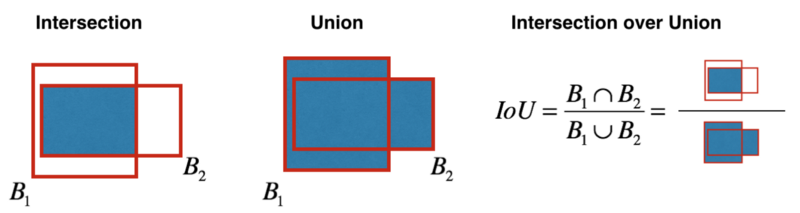

IOU is calculated as follows

1. Calculate the area of intersection, height * width \(as bounding box is a rectangle/)

2. Calculate the area of union as follows area\_union = groundtruth\_area + predicted\_area - area of intersection

3. Calculate the IOU value and store it in the variable 'iou'

In [ ]:
def get_iou(ground_truth, pred):

    ix1 = np.maximum(ground_truth[0], pred[0])
    iy1 = np.maximum(ground_truth[1], pred[1])
    ix2 = np.minimum(ground_truth[2], pred[2])
    iy2 = np.minimum(ground_truth[3], pred[3])

    ## YOUR CODE STARTS HERE ##

    # Calculate area of intersection
    i_height = np.maximum(0,iy2 - iy1+1)
    i_width = np.maximum(0,ix2 - ix1+1)
    area_of_intersection = i_height * i_width

    # Calculate Ground Truth Height and Width
    gt_height = ground_truth[3] - ground_truth[1]+1
    gt_width = ground_truth[2] - ground_truth[0]+1

    # Calculate Predicted Height and Width
    pd_height = pred[3] - pred[1]+1
    pd_width = pred[2] - pred[0]+1

    # Calculate Area of Union
    area_of_union = (gt_height * gt_width + pd_height * pd_width - area_of_intersection)

    # Calculate iou
    iou = area_of_intersection / float(area_of_union)

    ## YOUR CODE ENDS HERE ##
    return iou

In [ ]:
ground_truth_bbox = np.array([1100, 113, 1450, 768], dtype=np.float32)

prediction_bbox = np.array([1262.0001, 102.0021, 1519.9832, 794.0033], dtype=np.float32)

iou = get_iou(ground_truth_bbox, prediction_bbox)
print('IOU: ', iou)

IOU:  0.43389307076627287


## Question 2

What is the IOU of the given ground truth and predicted bounding box? (Rounded off to 4 digits)

a) 0.4339 \\
b) 0.4353 \\
c) 0.4354 \\
d) 0.4369



We will implement Multi-Task Loss for Fast R-CNN by extending the nn class of pythorch. Given the predicted logits, one-hot encoding of actual class labels, ground truth bounding box regression targets and predicted bounding box regression offsets it should return the loss value




In [ ]:
class MultiTaskLoss(nn.Module):

    def __init__(self, alpha = 0.1):
        super().__init__()
        self.alpha = alpha
        #### YOUR CODE STARTS HERE ####
        # Initialize a SmoothL1Loss function from the nn class of pytorch with 'sum' as reduction parameter
        self.smooth_l1_loss = nn.SmoothL1Loss(reduction = 'sum')
        #### YOUR CODE ENDS HERE ####

    def forward(self, pred_logits, true_class, bounding_box_offsets, bounding_box_target): # refer the later code for interpretation of the params
        #### YOUR CODE STARTS HERE ####
        # Calculate predicted class probabilities by taking softmax of predicted logits
        pred = torch.softmax(pred_logits, dim=-1)


        # Calculate the classification loss(Cross Entropy)
        true_class_index = torch.argmax(true_class) #index of the true class
        L_cls = -torch.log(pred[true_class_index])

        # Get the bounding box regression offsets for true class
        t_u = bounding_box_offsets[true_class_index]
        L_loc = 0  # Localization Loss
        # Calculate localization loss only for non background class
        if true_class_index > 0: # give appropiate condition
          # Calculate the localization loss(smooth L1 loss) between the true bounding box regression targets
          # and the bounding box offsets computed above while applying the smooth_l1_loss function initialised above
          L_loc = self.smooth_l1_loss(bounding_box_target, t_u)

        # Calculate the Multi Task loss from the two losses while using alpha as the scaling factor for the localization loss
        Loss = L_cls + self.alpha * L_loc
        #### YOUR CODE ENDS HERE ####
        return Loss

In [ ]:
# create an object of MultiTaskLoss
mt_loss=MultiTaskLoss(alpha = 0.01)

In [ ]:
# Assume predicted are the predicted logits
predicted_logits=torch.tensor([1.4315, 2.9862, 0.4019, 1.5501])
#One hot encoding of the true class
true_class=torch.tensor([0., 1., 0., 0.])
# Class wise predicted bounding box offsets
bounding_box_offsets = torch.tensor([[25., 51., 82., 120.],[63., 42., 103., 75.],[158., 26., 94., 56.],[15., 86., 44., 80.]])
# Bounding box regression target
bounding_box_target = torch.tensor([58., 35., 108., 81.])

In [ ]:
# Calculate multi task loss based on the above values
# Use the MultiTaskLossMultiTaskLoss object created above
# Print the value
print(mt_loss(predicted_logits,true_class, bounding_box_offsets, bounding_box_target))

tensor(0.6317)


## Question 3:

What is the value of the multi-task loss obtained above ?

a) 0.6317 \\
b) 0.7329 \\
c) 1.0435 \\
d) 0.8226



# WEEK 8

**Welcome to Assignment 8 on Deep Learning for Computer Vision.**

This assignment is based on the content you learned in Week-8 of the course.


#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'. You should not change anything else in the code cells. If you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

In this assignment, we will be fitting an LSTM to a cosine wave.

In [ ]:
# Please DO NOT modify this cell.

import os
import os.path as osp
import random

import numpy as np
import torch

def set_seed(seed: int):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(1)

In [ ]:
import matplotlib.pyplot as plt
import torch.nn as nn

## Prepare the training and testing dataset.

In [ ]:
# Please DO NOT modify this cell.

def get_data():

    train_x = np.arange(0, 100, 0.5)
    train_data = np.cos(train_x)

    test_x = np.arange(100, 200, 0.5)
    test_data = np.cos(test_x)

    return train_x, train_data, test_x, test_data

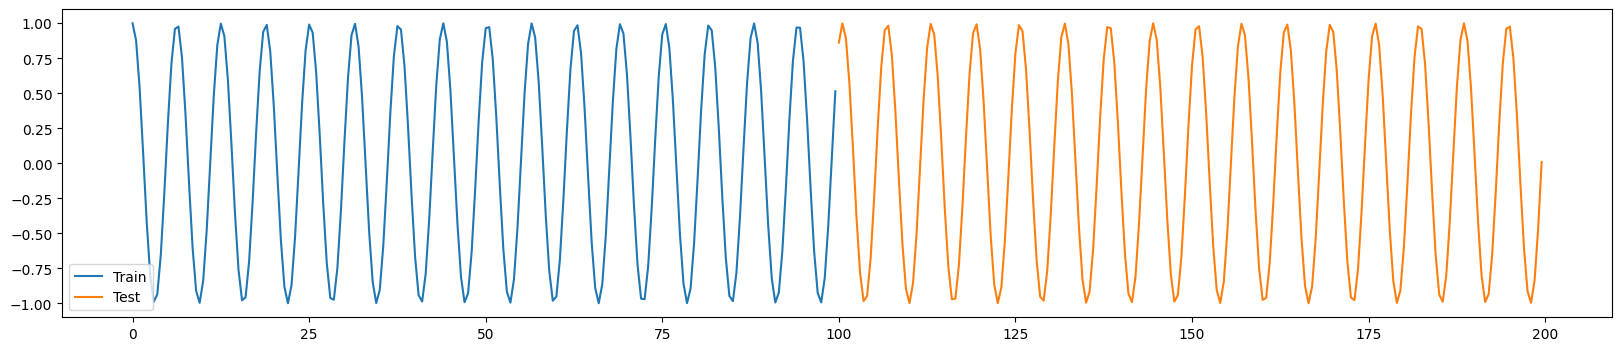

In [ ]:
# Please DO NOT modify this cell.

train_x, train_data, test_x, test_data = get_data()

plt.figure(figsize = (20, 4))
plt.plot(train_x, train_data, label = 'Train')
plt.plot(test_x, test_data, label = 'Test')

plt.legend(loc = "lower left")
plt.show()

In [ ]:
# Please DO NOT modify this cell.
"""
Functions for creating sliding windows from the data, this is a useful function
to understand for any time-series prediction task
"""

def sliding_windows(data, seq_length):

    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [ ]:
# Please DO NOT modify this cell.

"""
Create sliding windows
"""

seq_length = 5
x_train, y_train = sliding_windows(train_data, seq_length)
x_test, y_test = sliding_windows(test_data, seq_length)

x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train).reshape(-1, 1)

x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test).reshape(-1, 1)

x_train = x_train[:, :, np.newaxis]
x_test = x_test[:, :, np.newaxis]

## Create the model

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        #### YOUR CODE STARTS HERE ####

        # Define a LSTM block and a Linear block
        # Set batch_first = True

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers,
                            batch_first = True)

        self.fc = nn.Linear(hidden_size, num_classes)

        #### YOUR CODE ENDS HERE ####

    def forward(self, x):

        #### YOUR CODE STARTS HERE ####

        # Propagate input through LSTM


        output, (hidden_out, cell_out) = self.lstm(x)
        # Flatten hidden_out and pass it through fc layer

        hidden_out = hidden_out.view(-1, self.hidden_size)
        out = self.fc(hidden_out)

        #### YOUR CODE ENDS HERE ####

        return out

## Training

In [ ]:
num_epochs = 350
learning_rate = 0.001

input_size = 1
hidden_size = 4
num_layers = 1

num_classes = 1

# Define LSTM model
lstm_model = LSTM(num_classes, input_size, hidden_size, num_layers)

# Set MSE loss as criterion
criterion = torch.nn.MSELoss()

# Use Adam optimizer
optimizer = torch.optim.Adam(lstm_model.parameters(), lr = learning_rate)

# Train the model

for epoch in range(1, num_epochs+1):

    #### YOUR CODE STARTS HERE ####

    # Pass x_train as input to the lstm network
    train_predict = lstm_model(x_train)

    # Clear gradients in the optimizer
    optimizer.zero_grad()

    # Calculate loss using criterion function
    loss = criterion(train_predict, y_train)

    # Calculate gradients with respect to the loss
    loss.backward()

    # Update parameters
    optimizer.step()

    #### YOUR CODE ENDS HERE ####

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs}, loss: {loss.item():.2f}")

Epoch 10/350, loss: 0.53
Epoch 20/350, loss: 0.51
Epoch 30/350, loss: 0.50
Epoch 40/350, loss: 0.49
Epoch 50/350, loss: 0.48
Epoch 60/350, loss: 0.47
Epoch 70/350, loss: 0.46
Epoch 80/350, loss: 0.45
Epoch 90/350, loss: 0.44
Epoch 100/350, loss: 0.43
Epoch 110/350, loss: 0.42
Epoch 120/350, loss: 0.41
Epoch 130/350, loss: 0.40
Epoch 140/350, loss: 0.39
Epoch 150/350, loss: 0.37
Epoch 160/350, loss: 0.35
Epoch 170/350, loss: 0.33
Epoch 180/350, loss: 0.30
Epoch 190/350, loss: 0.27
Epoch 200/350, loss: 0.24
Epoch 210/350, loss: 0.21
Epoch 220/350, loss: 0.17
Epoch 230/350, loss: 0.14
Epoch 240/350, loss: 0.11
Epoch 250/350, loss: 0.08
Epoch 260/350, loss: 0.06
Epoch 270/350, loss: 0.05
Epoch 280/350, loss: 0.03
Epoch 290/350, loss: 0.03
Epoch 300/350, loss: 0.02
Epoch 310/350, loss: 0.01
Epoch 320/350, loss: 0.01
Epoch 330/350, loss: 0.01
Epoch 340/350, loss: 0.01
Epoch 350/350, loss: 0.01


In [ ]:
print(sum(p.numel() for p in lstm_model.parameters()))

117


## Question 4:

How many parameters are there in the model?

a) 117 \\
b) 234 \\
c) 115 \\
d) 236 \\



In [ ]:
lstm_model.eval()

with torch.no_grad():
    pred = lstm_model(x_test)

test_loss = criterion(pred, y_test)
print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0059


## Question 5:

What is the mean squared error loss on the test set? (select the nearest value)

a) 0.2187 \\
b) 0.0059 \\
c) 1.9696 \\
d) 0.5497


We will now create function that calculates the GRU cell operations as shown below

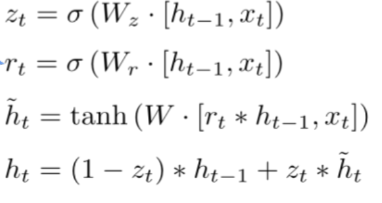

In [ ]:
import numpy as np
import torch

In [ ]:
## DO NOT CHANGE THIS ##
h_size = 20
N = 60

torch.manual_seed(0)

Wz = torch.rand((h_size, N))

Wr = torch.rand((h_size, N))

Wh = torch.rand((h_size, N))

x = torch.randn((40, 1))
h_prev = torch.randn((20,1))

Step 1: Append the h_prev and input x  along the row dimension.

Step 2: Calculate zt as shown in the above equation using sigmoid function and matrix multiplication and store it in variable 'z'

Step 3: Calculate rt as shown in the above equation using sigmoid function and matrix multiplication and store it in variable 'r'

Step 4: Calculate h_hat using tanh function as shown in third equation in the above picture and also make sure you perform elementwise mutliplication of r and h_prev before appending this to input x

Step 5: Calculate ht as shown in the last equation of the above picture, using elemetwise multiplication operation, and store it in the variable 'h_t'

In [ ]:
# Step 1: Append the h_prev and input x along the row dimension.
input = torch.cat((h_prev, x))

# Step 2: Calculate zt as shown in the above equation using sigmoid function and matrix multiplication and store it in variable 'z'
z = torch.sigmoid(torch.matmul(Wz, input))

# Step 3: Calculate rt as shown in the above equation using sigmoid function and matrix multiplication and store it in variable 'r'
r = torch.sigmoid(torch.matmul(Wr, input))

# Step 4: Calculate h_hat using tanh function as shown in the third equation in the above picture and also make sure you perform elementwise multiplication of r and h_prev before appending this to input x
temp = torch.cat((x, h_prev * r))
h_hat = torch.tanh(torch.matmul(Wh, temp))

# Step 5: Calculate ht as shown in the last equation of the above picture, using elementwise multiplication operation, and store it in the variable 'h_t'
h_t = (1 - z) * h_prev + z * h_hat

In [ ]:
print(torch.mean(h_t))

tensor(-0.3015)


## Question 6

What is the mean of the above h_t tensor?

a) -0.3914 \\
b) -0.3051 \\
c) -0.3015 \\
d) -0.3593